faces.zip extracted successfully into 'data/'
Total images loaded: 3836
Corrupted/unreadable images: 0
Image size (after resize): {(128, 128, 3)}
Images with exactly 1 face: 1558


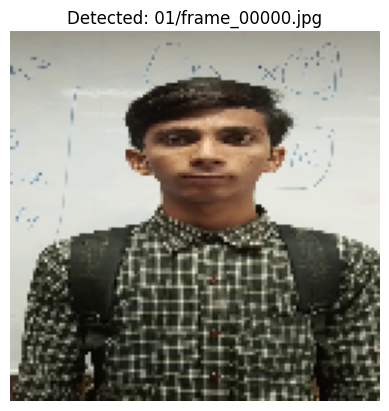

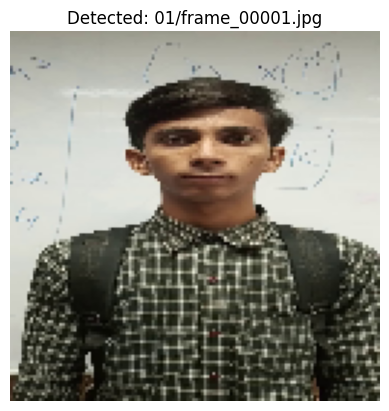

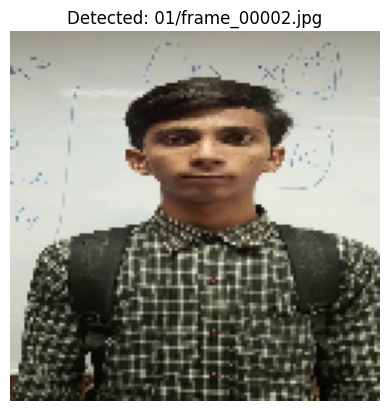

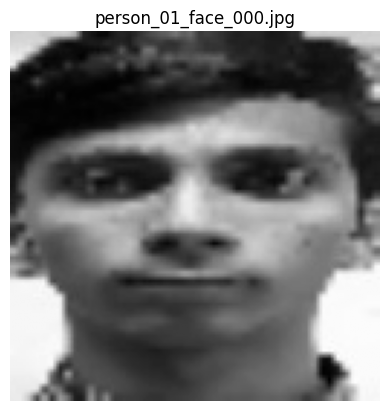

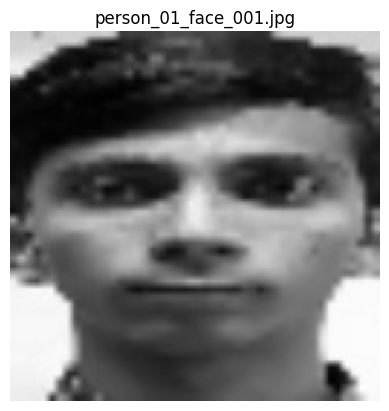

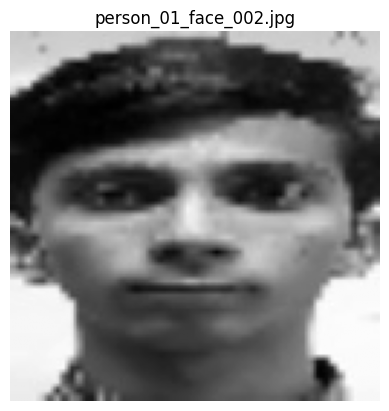

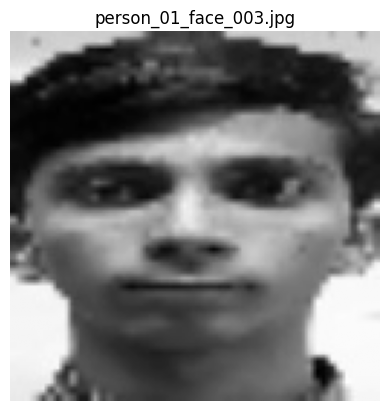

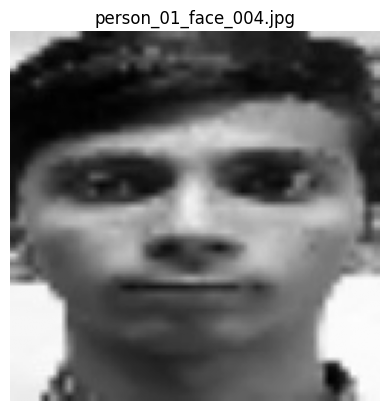

HOG features extracted: 1558
LBP features extracted: 1558
SIFT features extracted: 1558
HOG feature vector length: 8100
LBP feature vector length: 10
SIFT feature vector length: 128
Combined feature shape: (1558, 8238)
Feature shape: (1558, 8238)
Number of samples: 1558
Unique labels: ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11']
Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

          01       1.00      1.00      1.00        28
          02       1.00      1.00      1.00        14
          03       1.00      1.00      1.00        19
          04       1.00      1.00      1.00         2
          05       1.00      1.00      1.00        56
          06       1.00      1.00      1.00        39
          07       1.00      1.00      1.00        17
          08       1.00      1.00      1.00        46
          09       1.00      1.00      1.00        41
          10       1.00      1.00      1.00        30
          11       1.00     

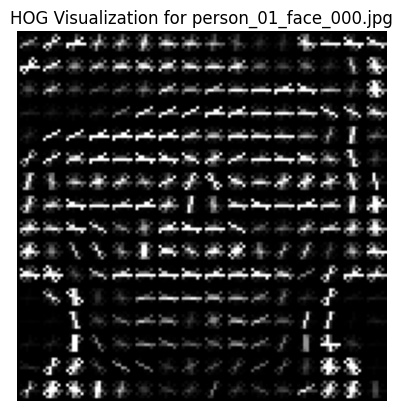

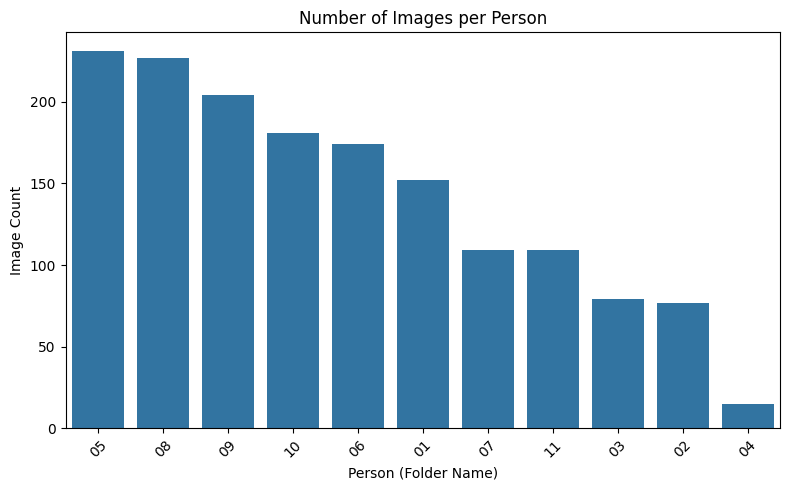

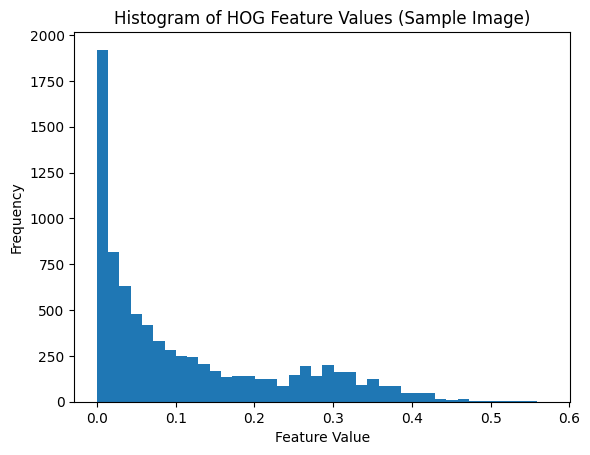

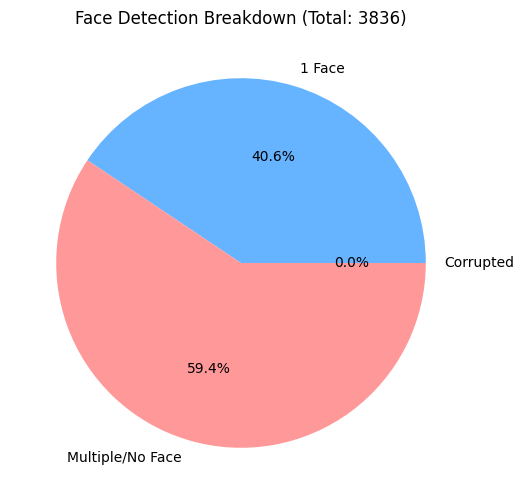

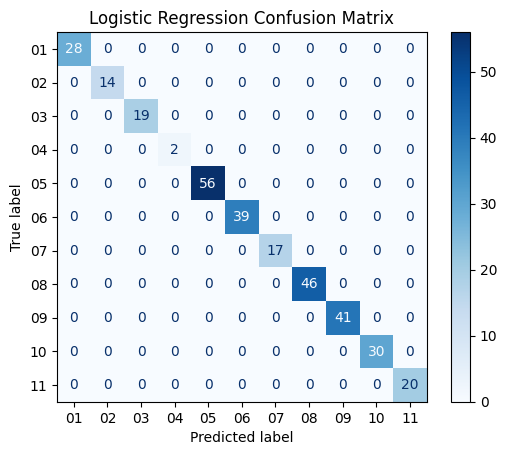

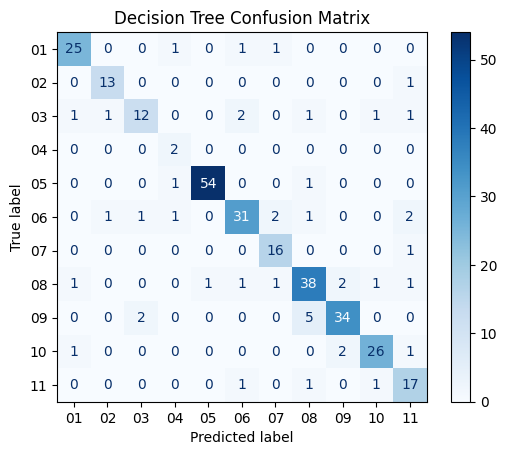

Logistic Regression 5-Fold CV Accuracy: 0.97 ± 0.03
Decision Tree 5-Fold CV Accuracy: 0.82 ± 0.03
Decision Tree Model, Label Encoder, and Scaler saved!


In [1]:
import zipfile
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
import joblib

# Step 1: Extract zip file
zip_path = "faces.zip"
extract_to = "data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("faces.zip extracted successfully into 'data/'")

# Step 2: Load images with folder information and resize
data_path = "data"
all_images = []
corrupted = []
image_sizes = []
for root, dirs, files in os.walk(data_path):
    for img_name in files:
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    corrupted.append(img_path)
                    continue
                img = cv2.resize(img, (128, 128))  # Normalize size
                folder_name = os.path.basename(root)
                all_images.append((img, folder_name, img_name))
                image_sizes.append(img.shape)
            except Exception as e:
                corrupted.append(img_path)

print(f"Total images loaded: {len(all_images)}")
print(f"Corrupted/unreadable images: {len(corrupted)}")
print(f"Image size (after resize): {set(image_sizes)}")

# Step 3: Face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces_detected = []
for img, folder_name, img_name in all_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 1:
        faces_detected.append((img, folder_name, img_name, faces[0]))

print(f"Images with exactly 1 face: {len(faces_detected)}")

if len(faces_detected) == 0:
    print("No images with 1 face found. Check image quality or Haar settings.")
else:
    for i in range(min(3, len(faces_detected))):
        img, folder_name, img_name, _ = faces_detected[i]
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected: {folder_name}/{img_name}")
        plt.axis('off')
        plt.show()

# Step 4: Save cropped faces with person information
output_folder = "cropped_faces"
os.makedirs(output_folder, exist_ok=True)
for i, (img, folder_name, img_name, (x, y, w, h)) in enumerate(faces_detected):
    cropped_face = img[y:y+h, x:x+w]
    gray_cropped = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)
    resized_face = cv2.resize(gray_cropped, (128, 128))
    save_filename = f"person_{folder_name}_face_{i:03d}.jpg"
    save_path = os.path.join(output_folder, save_filename)
    cv2.imwrite(save_path, resized_face)

# Step 5: Display sample cropped faces
sample_paths = os.listdir(output_folder)[:5]
for img_name in sample_paths:
    img = mpimg.imread(os.path.join(output_folder, img_name))
    plt.imshow(img, cmap='gray')
    plt.title(img_name)
    plt.axis('off')
    plt.show()

# Step 6: Extract HOG, LBP, and SIFT features
image_folder = 'cropped_faces'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
labels = []
hog_features = []
lbp_features = []
sift_features = []
sift = cv2.SIFT_create()

for f in image_files:
    parts = f.split('_')
    if len(parts) >= 2:
        label = parts[1]
        labels.append(label)
    else:
        print(f"Warning: Could not extract label from {f}")
        continue
    img_path = os.path.join(image_folder, f)
    img = cv2.imread(img_path, 0)
    try:
        # HOG
        hog_feat = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(hog_feat)
        # LBP
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float") / (hist.sum() + 1e-6)
        lbp_features.append(hist)
        # SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        sift_feat = np.mean(descriptors, axis=0) if descriptors is not None else np.zeros(128)
        sift_features.append(sift_feat)
    except Exception as e:
        print(f"Feature extraction failed on {f}: {e}")
        continue

print(f"HOG features extracted: {len(hog_features)}")
print(f"LBP features extracted: {len(lbp_features)}")
print(f"SIFT features extracted: {len(sift_features)}")
if hog_features:
    print(f"HOG feature vector length: {len(hog_features[0])}")
if lbp_features:
    print(f"LBP feature vector length: {len(lbp_features[0])}")
if sift_features:
    print(f"SIFT feature vector length: {len(sift_features[0])}")

# Step 6d: Combine features
assert len(hog_features) == len(lbp_features) == len(sift_features) == len(labels), \
    "Feature and label lists must have the same length"

combined_features = []
for i in range(len(hog_features)):
    combined = np.concatenate([hog_features[i], lbp_features[i], sift_features[i]])
    combined_features.append(combined)

X_combined = np.array(combined_features)
print("Combined feature shape:", X_combined.shape)

# Step 7: Encode labels and normalize features
le = LabelEncoder()
y_combined = le.fit_transform(labels)
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

print("Feature shape:", X_combined.shape)
print("Number of samples:", len(y_combined))
print("Unique labels:", le.classes_)

# Step 7b: Split data and train models with class weights
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, target_names=le.classes_))

# Decision Tree
tree = DecisionTreeClassifier(class_weight=class_weight_dict)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))

# Step 8: Interpretability - Feature Importance for Logistic Regression
hog_len = len(hog_features[0])
lbp_len = len(lbp_features[0])
coeffs = log_reg.coef_[0]
top_indices = np.argsort(np.abs(coeffs))[-10:][::-1]
print("Top 10 Influential Features for Logistic Regression:")
for idx in top_indices:
    if idx < hog_len:
        print(f"Feature {idx} (HOG): weight = {coeffs[idx]:.4f}")
    elif idx < hog_len + lbp_len:
        print(f"Feature {idx} (LBP): weight = {coeffs[idx]:.4f}")
    else:
        print(f"Feature {idx} (SIFT): weight = {coeffs[idx]:.4f}")

print("\nFeature type ranges:")
print(f"HOG features: indices 0 to {hog_len-1}")
print(f"LBP features: indices {hog_len} to {hog_len+lbp_len-1}")
print(f"SIFT features: indices {hog_len+lbp_len} to {len(X_combined[0])-1}")

# Step 9: Interpretability - Decision Tree Rules
from sklearn.tree import export_text
tree_rules = export_text(tree, feature_names=[f'f{i}' for i in range(X_combined.shape[1])])
print("Decision Tree Rules:\n", tree_rules)

# Step 10: Interpretability - Visualize HOG Features
img = cv2.imread(os.path.join(image_folder, image_files[0]), 0)
fd, hog_image = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title(f"HOG Visualization for {image_files[0]}")
plt.axis('off')
plt.show()

# Step 11: Visualize Label Distribution
label_df = pd.DataFrame({'filename': image_files, 'label': labels})
label_counts = label_df['label'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Number of Images per Person")
plt.xlabel("Person (Folder Name)")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 12: Visualize Histogram of HOG Feature Values
plt.hist(hog_features[0], bins=40)
plt.title("Histogram of HOG Feature Values (Sample Image)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()

# Step 13: Visualize Face Detection Breakdown
total = len(all_images)
valid = len(faces_detected)
corrupt = len(corrupted)
multi = max(0, total - valid - corrupt)
plt.figure(figsize=(6, 6))
plt.pie([valid, multi, corrupt], labels=["1 Face", "Multiple/No Face", "Corrupted"],
        autopct='%1.1f%%', colors=['#66b3ff', '#ff9999', '#ffcc99'])
plt.title(f"Face Detection Breakdown (Total: {total})")
plt.show()

# Step 14: Visualize Confusion Matrices
models = {"Logistic Regression": y_pred_log, "Decision Tree": y_pred_tree}
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Step 15: Cross-Validation
for model, name in [(log_reg, "Logistic Regression"), (tree, "Decision Tree")]:
    scores = cross_val_score(model, X_combined, y_combined, cv=5)
    print(f"{name} 5-Fold CV Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

# Step 16: Save Decision Tree Model, Label Encoder, and Scaler
joblib.dump(tree, 'model.pkl')
joblib.dump(le, 'le.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Decision Tree Model, Label Encoder, and Scaler saved!")

# Step 17: Real-Time Facial Recognition GUI
model = joblib.load("model.pkl")
label_encoder = joblib.load("le.pkl")
scaler = joblib.load("scaler.pkl")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
sift = cv2.SIFT_create()
cap = None
lbl = None
running = False

def start_camera():
    global cap, running, lbl
    if not running:
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            messagebox.showerror("Error", "Cannot open camera")
            return
        running = True
        lbl = Label(root, bg="black")
        lbl.pack(pady=10)
        update_frame()

def stop_camera():
    global cap, running, lbl
    running = False
    if cap:
        cap.release()
        cap = None
    if lbl:
        lbl.destroy()
        lbl = None

def update_frame():
    global cap, lbl, running
    if running and cap:
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
            for (x, y, w, h) in faces:
                face_roi = gray[y:y+h, x:x+w]
                resized = cv2.resize(face_roi, (128, 128))
                # Extract all features
                hog_feat = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
                radius = 1
                n_points = 8 * radius
                lbp = local_binary_pattern(resized, n_points, radius, method='uniform')
                (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
                hist = hist.astype("float") / (hist.sum() + 1e-6)
                keypoints, descriptors = sift.detectAndCompute(resized, None)
                sift_feat = np.mean(descriptors, axis=0) if descriptors is not None else np.zeros(128)
                features = np.concatenate([hog_feat, hist, sift_feat])
                features = scaler.transform([features])
                pred = model.predict(features)[0]
                label = label_encoder.inverse_transform([pred])[0]
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                # Detect eyes and mouth
                eyes = eye_cascade.detectMultiScale(face_roi)
                for (ex, ey, ew, eh) in eyes:
                    cv2.rectangle(frame, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (255, 0, 0), 2)
                mouth_rects = mouth_cascade.detectMultiScale(face_roi, scaleFactor=1.5, minNeighbors=20)
                for (mx, my, mw, mh) in mouth_rects:
                    if my > h//2:
                        cv2.rectangle(frame, (x+mx, y+my), (x+mx+mw, y+my+mh), (0, 0, 255), 2)
                        break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb)
            imgtk = ImageTk.PhotoImage(image=img)
            if lbl:
                lbl.imgtk = imgtk
                lbl.configure(image=imgtk)
        lbl.after(10, update_frame)

# Set up Tkinter GUI
root = Tk()
root.title("Facial Recognition System")
root.configure(bg="#2e2e2e")
root.geometry("720x600")
title = Label(root, text="Facial Recognition", font=("Helvetica", 18, "bold"), fg="white", bg="#2e2e2e")
title.pack(pady=20)
btn_frame = Frame(root, bg="#2e2e2e")
btn_frame.pack(pady=10)
start_btn = Button(btn_frame, text="Start", command=start_camera, bg="#28a745", fg="white", font=("Arial", 12), width=10)
start_btn.pack(side=LEFT, padx=20)
stop_btn = Button(btn_frame, text="Stop", command=stop_camera, bg="#dc3545", fg="white", font=("Arial", 12), width=10)
stop_btn.pack(side=RIGHT, padx=20)
root.mainloop()